In [172]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [173]:
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
import re

In [174]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
data = [train_df, test_df]

In [175]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# First Data Exploration:

In [176]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


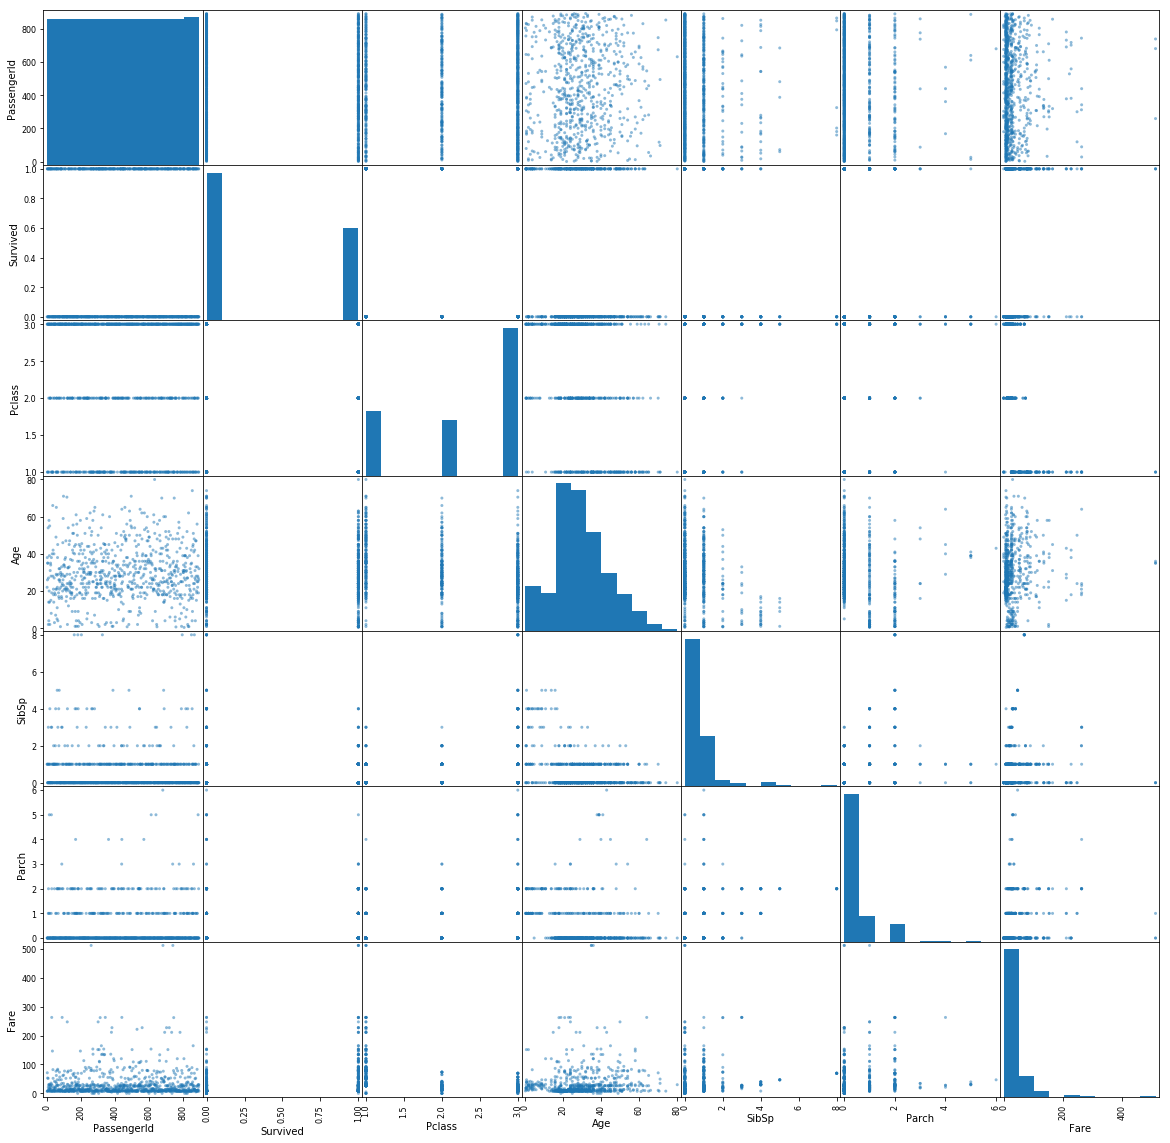

In [177]:
# Exploring corelations between all numeric features (not really easy to read...)
pd.plotting.scatter_matrix(train_df, figsize=(20,20))
plt.show()

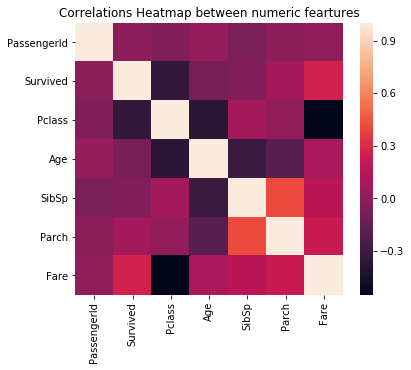

In [178]:
# Exploring corelations between all numeric features
corr = train_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr)
plt.title('Correlations Heatmap between numeric feartures')
plt.show()

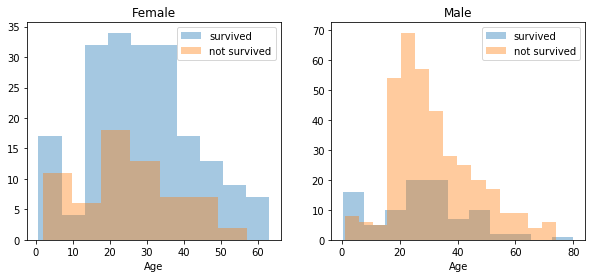

In [179]:
# Studying survival chance related to gender and age
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

# Plotting women chance of survival in relation to their age
sns.distplot(women[women['Survived']==1].Age.dropna() , label = 'survived', ax = axes[0], kde =False)
sns.distplot(women[women['Survived']==0].Age.dropna() , label = 'not survived', ax = axes[0], kde =False)
axes[0].legend()
axes[0].set_title('Female')

# Plotting men chance of survival in relation to their age
sns.distplot(men[men['Survived']==1].Age.dropna() , label = 'survived', ax = axes[1], kde = False)
sns.distplot(men[men['Survived']==0].Age.dropna() , label = 'not survived', ax = axes[1], kde = False)
axes[1].legend()
axes[1].set_title('Male')

plt.show()

In [180]:
# Studying survival chance related to presence of age data
print("Average survival rate among all train data passengers : {}%".format(round(train_df['Survived'].mean(), 2)))
print("Average survival rate among passengers with no age data: {}%".format(round(train_df[train_df['Age'].isnull()]['Survived'].mean(), 2)))
print("Average survival rate among passengers with age data: {}%".format(round(train_df[train_df['Age'].notnull()]['Survived'].mean(), 2)))

Average survival rate among all train data passengers : 0.38%
Average survival rate among passengers with no age data: 0.29%
Average survival rate among passengers with age data: 0.41%


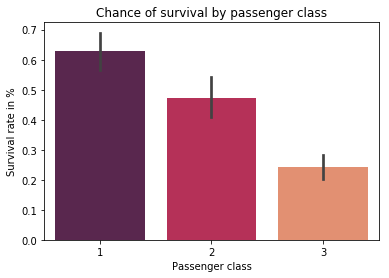

In [181]:
# Studying survival chance related to passenger class
sns.barplot(x='Pclass', y='Survived', palette='rocket', data=train_df)
plt.ylabel('Survival rate in %')
plt.xlabel('Passenger class')
plt.title('Chance of survival by passenger class')
plt.show()

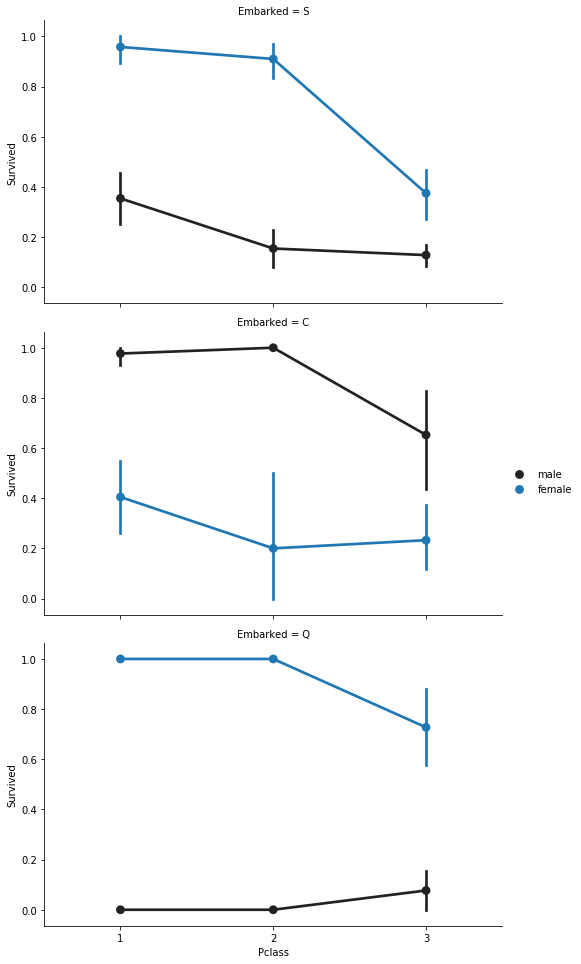

In [182]:
#Embarked, Pclass, Sex
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()
plt.show()

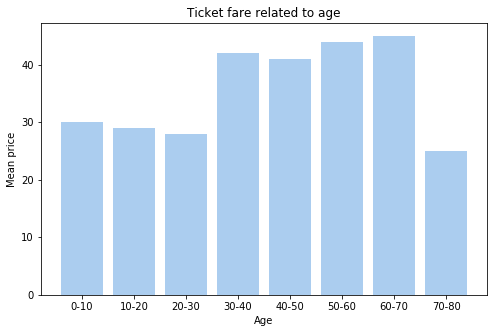

In [183]:
# Studying ticket fare related to age
bins = [0,10,20,30,40,50,60,70,80]
bins2 = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']

groups = train_df.groupby(pd.cut(train_df.Age, bins))

plt.figure(figsize=(8,5))
plt.bar(bins2, np.array(groups.mean()['Fare'].astype(int)), color='#abcdef')
plt.title('Ticket fare related to age')
plt.xlabel('Age')
plt.ylabel('Mean price')
plt.show()

# Preprocessing

In [184]:
# Gender data preprocessing
# Replacing male and female references by numeric values
Sex = {'male': 0, 'female': 1}
for dataset in data:
    dataset.Sex = dataset.Sex.map(Sex)

In [185]:
# Cabin data preprocessing
# Filling NaN Cabin data and adding Decks referenced by Cabin letters

#deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
deck = {"A": 2, "B": 6, "C": 4, "D": 8, "E": 7, "F": 5, "G": 3, "U": 1}
tofind = re.compile("([a-zA-Z]+)")
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: tofind.search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(8)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,S,1


In [186]:
for decknb in range(1,9): 
    print("deck{} survival rate : {}".format(decknb,train_df[train_df['Deck'] == decknb]['Survived'].mean()))

deck1 survival rate : 0.29985443959243085
deck2 survival rate : 0.4666666666666667
deck3 survival rate : 0.5
deck4 survival rate : 0.5932203389830508
deck5 survival rate : 0.6153846153846154
deck6 survival rate : 0.7446808510638298
deck7 survival rate : 0.75
deck8 survival rate : 0.7352941176470589


In [187]:
# Port embarked preprocessing
# Removing NaN values (count : 2)
ports = {"S": 1, "Q": 2, "C": 3}
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map(ports)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,1,1


In [188]:
train_df.groupby(['Embarked']).mean()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck
Embarked,,,,,,,,,
1,449.517028,0.339009,2.346749,0.317337,29.519335,0.569659,0.411765,27.243651,1.922601
2,417.896104,0.389610,2.909091,0.467532,28.089286,0.428571,0.168831,13.276030,1.207792
3,445.357143,0.553571,1.886905,0.434524,30.814769,0.386905,0.363095,59.954144,2.815476


In [189]:
# Preprocessing titles
# Ordering them by rate of survival
titles = {'Mr': 1, 'Rare': 2, 'Master': 3, 'Miss': 4, 'Mrs': 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)

In [190]:
print("Unique titles:\n{}".format(train_df['Title'].unique()))
print("\nNumber of passengers by title:\n{}".format(train_df['Title'].value_counts()))
print("\nRate of Survival by title:\n{}".format(train_df.groupby(['Title'])['Survived'].mean()))

Unique titles:
[1 5 4 3 2]

Number of passengers by title:
1    517
4    185
5    126
3     40
2     23
Name: Title, dtype: int64

Rate of Survival by title:
Title
1    0.156673
2    0.347826
3    0.575000
4    0.702703
5    0.793651
Name: Survived, dtype: float64


In [191]:
# Analysis : age by title
reverse_title = {1:'Mr', 2:'Rare', 3:'Master', 4:'Miss', 5:'Mrs'}
for title in range(1,6):
    print('Title : {}'.format(reverse_title[title]))
    print('train set : {}'.format(round(train_df[(train_df['Title'] == title) & (train_df['Age'].notnull())]['Age'].mean())))
    print('test set : {}\n'.format(round(test_df[(test_df['Title'] == title) & (test_df['Age'].notnull())]['Age'].mean())))

Title : Mr
train set : 32
test set : 32

Title : Rare
train set : 46
test set : 44

Title : Master
train set : 5
test set : 7

Title : Miss
train set : 22
test set : 22

Title : Mrs
train set : 36
test set : 39



In [192]:
# Age : Do a column for unknown age
# Age : Remove NaNs by putting mean() according to title
# Cabin : Study same cabin chance of survival
# Siblings and parch analysis ?
# Relations analysis ?

In [193]:
# Adding Known_age column as passenger with age data are more likely to survive
known_age = {False: 0, True: 1}

for dataset in data:
    dataset['Known_age'] = dataset['Age'].notnull()
    dataset['Known_age'] = dataset['Known_age'].map(known_age)

In [194]:
# Create Family Name column for further exploration
# A FAIRE POUR TEST AUSSI SI JE LE GARDE

#tofind = re.compile('([A-Za-z]+)')
#train_df['Family_name'] = train_df['Name'].map(lambda x: tofind.search(x).group())

In [195]:
#train_df['Family_name'].value_counts().head(30)

In [196]:
#train_df[train_df['Family_name'] == 'Johnson']

In [197]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Known_age
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,1,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3,4,5,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,1,1,4,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1,4,5,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,U0,1,1,2,1
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,1,6,4,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,U0,1,1,4,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,3,4,1,1


In [198]:
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [199]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U0,1,1,1,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3,4,5,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U0,1,1,4,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1,4,5,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,U0,1,1,2,1,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,1,6,4,1,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,U0,1,1,4,0,4,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,3,4,1,1,1,1


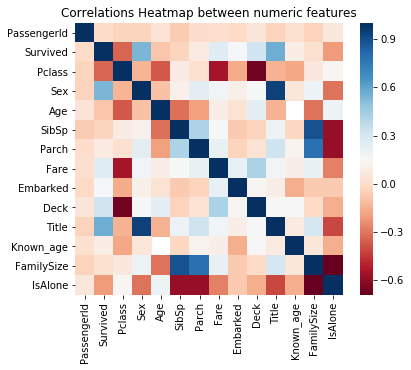

In [200]:
# New exploration of correlations
corr = train_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="RdBu")
plt.title('Correlations Heatmap between numeric features')
plt.show()

In [201]:
# Replace missing age data by age mean for each title

for dataset in data:
    title_means = {}
    for title in range(1,6):
        title_means.update({title:round(dataset.loc[(dataset['Title'] == title) & (dataset['Age'].notnull())]['Age'].mean())})
    for title in range(1,6):
        dataset.loc[(dataset['Title'] == title) & (dataset['Age'].isnull()), 'Age'] = title_means[title]

In [202]:
# Replace missing fare data for PassengerId 1044 (index 152) in test data
test_df.loc[152 ,'Fare'] = test_df['Fare'].mean()

In [203]:
PassengerIds = test_df['PassengerId']

In [204]:
for dataset in data:
    dataset.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [205]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,0,3,0,22,1,0,7,1,1,1,1,2,0
1,1,1,1,38,1,0,71,3,4,5,1,2,0
2,1,3,1,26,0,0,7,1,1,4,1,1,1
3,1,1,1,35,1,0,53,1,4,5,1,2,0
4,0,3,0,35,0,0,8,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27,0,0,13,1,1,2,1,1,1
887,1,1,1,19,0,0,30,1,6,4,1,1,1
888,0,3,1,22,1,2,23,1,1,4,0,4,0
889,1,1,0,26,0,0,30,3,4,1,1,1,1


In [206]:
#Categorie for Age:

for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

train_df['Age'].value_counts()

4    245
6    149
2    128
5    120
3    106
0     72
1     71
Name: Age, dtype: int64

In [207]:
#Categorie for Fare
pd.qcut(train_df['Fare'], 5)
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7) & (dataset['Fare'] <= 10), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 21), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 21) & (dataset['Fare'] <= 39), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 39) & (dataset['Fare'] <= 512), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 512, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [208]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,0,3,0,2,1,0,0,1,1,1,1,2,0
1,1,1,1,5,1,0,4,3,4,5,1,2,0
2,1,3,1,3,0,0,0,1,1,4,1,1,1
3,1,1,1,5,1,0,4,1,4,5,1,2,0
4,0,3,0,5,0,0,1,1,1,1,1,1,1


Optimisation possible : 
- Pour récupérer les moyennes d'âge, utiliser la moyenne des 2 jeux de données pour le titre concerné
- Utiliser un Scaler : Standard ou MinMax pour normaliser / standardiser les données
- Les cabines en tant que strings sont-elles utilisables ?

# Initiating Train / Test sub datasets

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
Y = pd.DataFrame.copy(train_df['Survived'])
X = train_df.drop(['Survived'], axis=1)

In [211]:
# Splitting sur train and test sets
# Stratify is used to have the same proportion in survival in both sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify = Y)

# Training models

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import SGDClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.naive_bayes import GaussianNB

In [213]:
rf_clf = RandomForestClassifier()
lg_clf = LogisticRegression()
sv_clf = SVC()
kn_clf = KNeighborsClassifier(4)
ln_clf = LinearRegression()
rg_clf = RidgeCV()
ls_clf = LassoCV()
en_clf = ElasticNetCV()

vt_clf = VotingClassifier(estimators=[('lg', lg_clf), ('rf', rf_clf), ('sv', sv_clf), ('kn', kn_clf), ('rg', rg_clf), ('ls', ls_clf), ('en', en_clf)],
                              # here we select hard voting, which returns the majority of the predictions, not an average of probabilities
                              voting='hard')

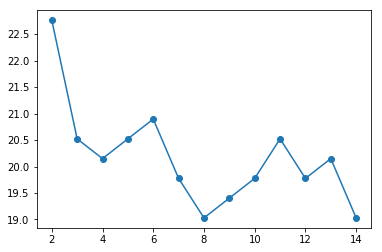

In [214]:
# Studying errors is KNN model depending of hyperparameter
errors = []
for k in range(2,15):
    knn = KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
    
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [215]:
rf_clf.fit(X_train, y_train)
lg_clf.fit(X_train, y_train)
sv_clf.fit(X_train, y_train)
kn_clf.fit(X_train, y_train)
ln_clf.fit(X_train, y_train)
rg_clf.fit(X_train, y_train)
ls_clf.fit(X_train, y_train)
en_clf.fit(X_train, y_train)

vt_clf.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/pyth

VotingClassifier(estimators=[('lg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',...
                                      se

In [216]:
rf_pred = rf_clf.predict(X_test)
lg_pred = lg_clf.predict(X_test)
sv_pred = sv_clf.predict(X_test)
ln_pred = ln_clf.predict(X_test)
kn_pred = kn_clf.predict(X_test)
rg_pred = rg_clf.predict(X_test)
ls_pred = rg_clf.predict(X_test)
en_pred = rg_clf.predict(X_test)

# vt_pred = vt_clf.predict(X_test)

In [217]:
ln_mean = ln_pred.mean()

ln_pred2 = []
for elem in ln_pred:
    if elem < ln_mean:
        ln_pred2.append(0)
    else:
        ln_pred2.append(1)

In [218]:
rg_mean = rg_pred.mean()

rg_pred2 = []
for elem in rg_pred:
    if elem < rg_mean:
        rg_pred2.append(0)
    else:
        rg_pred2.append(1)

In [219]:
ls_mean = ls_pred.mean()

ls_pred2 = []
for elem in ls_pred:
    if elem < ls_mean:
        ls_pred2.append(0)
    else:
        ls_pred2.append(1)

In [220]:
en_mean = en_pred.mean()

en_pred2 = []
for elem in en_pred:
    if elem < en_mean:
        en_pred2.append(0)
    else:
        en_pred2.append(1)

In [221]:
from sklearn.metrics import accuracy_score

print("Accuracy score :")
print("Random Forest : {}".format(accuracy_score(y_test, rf_pred)))
print("Logistic Regr : {}".format(accuracy_score(y_test, lg_pred)))
print("SVM : {}".format(accuracy_score(y_test, sv_pred)))
print("K Neighbors : {}".format(accuracy_score(y_test, kn_pred)))

print("\nTEST:")
print("Linear Regression : {}".format(accuracy_score(y_test, ln_pred2)))
print("Ridge CV : {}".format(accuracy_score(y_test, rg_pred2)))
print("Lasso CV : {}".format(accuracy_score(y_test, ls_pred2)))
print("Elastic CV : {}".format(accuracy_score(y_test, en_pred2)))

#print("Voting : {}".format(accuracy_score(y_test, vt_pred)))

Accuracy score :
Random Forest : 0.7910447761194029
Logistic Regr : 0.835820895522388
SVM : 0.8283582089552238
K Neighbors : 0.7985074626865671

TEST:
Linear Regression : 0.7985074626865671
Ridge CV : 0.7947761194029851
Lasso CV : 0.7947761194029851
Elastic CV : 0.7947761194029851


In [222]:
y_pred = lg_clf.predict(X_test)
lg_clf.score(X_train, y_train)

0.8394863563402889

In [223]:
# model = RandomizedSearchCV

Random Forest Classifier

First try accuracy_score : 0.7985

Second try with Cabin reordered : 0.8059

Third try (Family Size + IsAlone) :

Rand Forest : 0.80

Log Regr : 0.82

SVM : 0.71

In [224]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Known_age,FamilySize,IsAlone
0,3,0,5,0,0,0,2,1,1,1,1,1
1,3,1,6,1,0,0,1,1,5,1,2,0
2,2,0,6,0,0,1,2,1,1,1,1,1
3,3,0,3,0,0,1,1,1,1,1,1,1
4,3,1,2,1,1,2,1,1,5,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,4,0,0,1,1,1,1,0,1,1
414,1,1,5,0,0,4,3,4,2,1,1,1
415,3,0,5,0,0,0,1,1,1,1,1,1
416,3,0,4,0,0,1,1,1,1,0,1,1


#Submission

In [225]:
predictions = lg_clf.predict(test_df)

output = pd.DataFrame({'PassengerId': PassengerIds, 'Survived': predictions})
output.to_csv('my_submission_18.01.20_sacha.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
